# Create data for Deep Model-based Pose refinement

In [ ]:
# !pip install torch==1.5.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install opencv-contrib-python

     |████████████████████████████████| 34.2MB 480kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


## Create Dataset for Pose Refiner

In [ ]:
!pip install opencv-python

     |████████████████████████████████| 28.2MB 3.4MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import unet_model as UNET
from torch.utils.data.sampler import SubsetRandomSampler
from create_ground_truth_helper import get_rot_tra
from pose_refiner_block import Pose_Refiner
from scipy.spatial.transform import Rotation as R
from helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
classes = {'ape':1, 'benchviseblue':2, 'bowl':3, 'can':4, 'cat':5, 'cup':6, 'driller':7, 
            'duck':8, 'glue':9, 'holepuncher':10, 'iron':11, 'lamp':12, 'phone':13, 'cam':14,'eggbox':15}

In [ ]:
correspondence_block = UNET.UNet(n_channels = 3, out_channels_id = 16, out_channels_uv = 256, bilinear=True)
if train_on_gpu:
    correspondence_block.cuda()

In [ ]:
correspondence_block.load_state_dict(torch.load('correspondence_block.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
class LineMODDataset(Dataset):

    """
    Args:
        root_dir (str): path to the dataset
        classes (dictionary): values of classes to extract from segmentation mask 
        transform : Transforms for input image
            """

    def __init__(self,root_dir,classes=None,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.list_all_images = load_obj(root_dir + "all_images_adr")
        self.training_images_idx = load_obj(root_dir + "train_images_indices")

    def __len__(self):
        return len(self.training_images_idx)
    def __getitem__(self, i):
        img_adr = self.list_all_images[self.training_images_idx[i]]
        label = os.path.split(os.path.split(os.path.dirname(img_adr))[0])[1]
        regex = re.compile(r'\d+')
        idx = regex.findall(os.path.split(img_adr)[1])[0]
        image = cv2.imread(img_adr) 
        IDmask = cv2.imread(self.root_dir + label + "/ground_truth/IDmasks/color" + str(idx) + ".png"
                                ,cv2.IMREAD_GRAYSCALE)
        Umask = cv2.imread(self.root_dir + label + "/ground_truth/Umasks/color" + str(idx) + ".png"
                                ,cv2.IMREAD_GRAYSCALE)
        Vmask = cv2.imread(self.root_dir + label + "/ground_truth/Vmasks/color" + str(idx) + ".png"
                                ,cv2.IMREAD_GRAYSCALE)
        # resize the masks
        IDmask = (IDmask/255)*self.classes[label] 
        image = cv2.resize(image,(image.shape[1]//2, image.shape[0]//2), interpolation=cv2.INTER_AREA)
        IDmask = cv2.resize(IDmask,(IDmask.shape[1]//2, IDmask.shape[0]//2), interpolation=cv2.INTER_AREA)
        Umask = cv2.resize(Umask,(Umask.shape[1]//2, Umask.shape[0]//2), interpolation=cv2.INTER_AREA)
        Vmask = cv2.resize(Vmask,(Vmask.shape[1]//2, Vmask.shape[0]//2), interpolation=cv2.INTER_AREA)
        if self.transform:
            image = self.transform(image)
        IDmask = (torch.from_numpy(IDmask)).type(torch.int64)
        Umask = (torch.from_numpy(Umask)).type(torch.int64)
        Vmask = (torch.from_numpy(Vmask)).type(torch.int64)
        return img_adr,image,IDmask,Umask,Vmask

In [ ]:
root_dir = "/home/jovyan/work/LineMOD_Dataset/"
train_data = LineMODDataset(
    root_dir, 
    classes = classes, 
    transform = transforms.Compose([transforms.ToTensor()])
)

In [ ]:
#Upsample the image:
upsampled = nn.Upsample(size=[240,320] ,mode='bilinear')

In [ ]:
x,_,_,_,_ = train_data[0]
x

'/home/jovyan/work/LineMOD_Dataset/bowl/data/color77.jpg'

## Create rendered images

In [ ]:
fx=572.41140; px=325.26110; fy=573.57043; py=242.04899 # Intrinsic Parameters of the Camera
intrinsic_matrix =  np.array([[fx, 0, px], [0, fy, py], [0, 0, 1]])

In [ ]:
data_dir = "/home/jovyan/work/LineMOD_Dataset/"

In [ ]:
def create_rendering(root_dir,obj,idx): # helper function to help with creating renderings
    pred_pose_adr = root_dir + obj + '/predicted_pose'+ '/info_' + str(idx) +".txt"
    rgb_values = np.loadtxt(root_dir + obj + '/object.xyz',skiprows=1,usecols = (6,7,8))
    coords_3d = np.loadtxt(root_dir + obj + '/object.xyz',skiprows=1,usecols = (0,1,2))
    ones = np.ones((coords_3d.shape[0],1))
    homogenous_coordinate = np.append(coords_3d, ones, axis=1)
    rigid_transformation = np.loadtxt(pred_pose_adr)
    # Perspective Projection to obtain 2D coordinates 
    homogenous_2D = intrinsic_matrix @ (rigid_transformation @ homogenous_coordinate.T)
    homogenous_2D[2,:][np.where(homogenous_2D[2,:] == 0)] = 1 # to ensure there is no division by 0
    coord_2D = homogenous_2D[:2,:] / homogenous_2D[2,:]
    coord_2D = ((np.floor(coord_2D)).T).astype(int)
    rendered_image = np.zeros ((480,640,3))
    x_2d = np.clip(coord_2D[:,0],0,480)
    y_2d = np.clip(coord_2D[:,1],0,640)
    rendered_image[x_2d,y_2d,:] = rgb_values
    non_zero_indices = np.argwhere(rendered_image > 0)
    min_x = non_zero_indices[:,0].min()
    max_x = non_zero_indices[:,0].max()
    y_min = non_zero_indices[:,1].min()
    y_max = non_zero_indices[:,1].max()
    cropped_rendered_image = rendered_image[min_x:max_x + 1,min_y:max_y + 1,:]
    if cropped_rendered_image.shape[0] > 240 or cropped_rendered_image.shape[1] > 320:
        cropped_rendered_image = cv2.resize(np.float32(cropped_rendered_image),(320,240),interpolation=cv2.INTER_AREA)
    return cropped_rendered_image


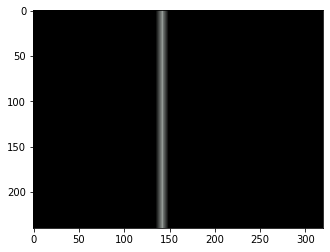

In [ ]:
regex = re.compile(r'\d+')
# for i in range(len(train_data)):
#     if i % 1000 == 0:
#         print(str(i) + "/" + str(len(train_data)) + "finished!")
img_adr,img,_, _ , _ = train_data[0]
label = os.path.split(os.path.split(os.path.dirname(img_adr))[0])[1]
idx = regex.findall(os.path.split(img_adr)[1])[0]
adr_rendered = data_dir + label + "/pose_refinement/rendered/color" + str(idx) +".png"
adr_img = data_dir + label + "/pose_refinement/real/color" + str(idx) +".png"
# find the object in the image using the idmask
img = img.view(1,img.shape[0],img.shape[1],img.shape[2])
idmask_pred,_,_ = correspondence_block(img.cuda())
idmask = torch.argmax(idmask_pred,dim=1).squeeze().cpu() 
coord_2d = (idmask == classes[label]).nonzero(as_tuple=True)
coord_2d = torch.cat((coord_2d[0].view(coord_2d[0].shape[0],1),coord_2d[1].view(coord_2d[1].shape[0],1)),1)
min_x = coord_2d[:,0].min()
max_x = coord_2d[:,0].max()
min_y = coord_2d[:,1].min()
max_y = coord_2d[:,1].max()
img = img.squeeze().transpose(1, 2).transpose(0,2)
obj_img = img[min_x:max_x+1,min_y:max_y+1,:]
#saving in the correct format using upsampling
obj_img = obj_img.transpose(0,1).transpose(0,2).unsqueeze(dim=0)
obj_img = upsampled(obj_img)
obj_img = obj_img.squeeze().transpose(0,2).transpose(0,1)
#mpimg.imsave(adr_img,obj_img.squeeze().numpy())
#plt.imshow(obj_img.squeeze().numpy())

#create rendering for an image
cropped_rendered_image = create_rendering(data_dir,label,idx)
# print("Plotting")
# plt.imshow(cropped_rendered_image)
rendered_img = torch.from_numpy(cropped_rendered_image)
rendered_img = rendered_img.unsqueeze(dim = 0)
rendered_img = rendered_img.transpose(1,3).transpose(2,3)
rendered_img = upsampled(rendered_img)
rendered_img = rendered_img.squeeze().transpose(0,2).transpose(0,1)
#mpimg.imsave(adr_rendered,rendered_img.numpy())
plt.imshow(rendered_img.squeeze().numpy())


TypeError: Image data of dtype object cannot be converted to float

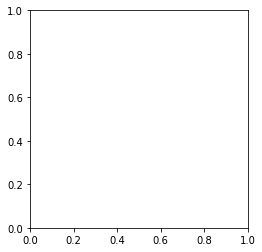

In [ ]:
z = cv2.imread("/home/jovyan/work/LineMOD_Dataset/bowl/ground_truth/IDmask/color77.png")
plt.imshow(z)

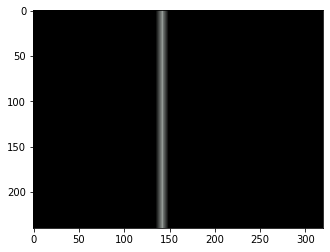

In [ ]:
plt.imshow(rendered_img.squeeze().numpy())


(240, 320, 3)


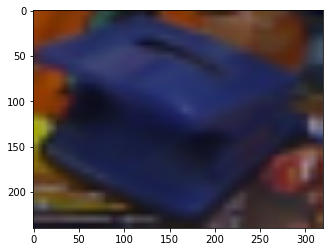

In [ ]:
y = cv2.imread(adr_img)
print(y.shape)
#y = y[...,::-1]
plt.imshow(y)

(240, 320, 3)


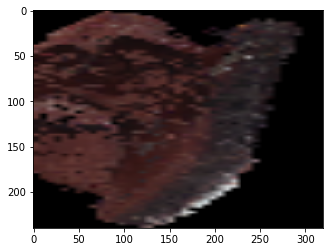

In [ ]:
z = cv2.imread(adr_rendered)
print(z.shape)
#z = z[...,::-1]
plt.imshow(z)

In [ ]:
class PoseRefinerDataset(Dataset):

    """
    Args:
        root_dir (str): path to the dataset directory
        classes (dict): dictionary containing classes as key  
        transform : Transforms for input image
            """
    def __init__(self,root_dir,classes=None,transform=None):
        self.root_dir = root_dir 
        self.transform = transform
        self.classes = classes
        self.list_all_images = load_obj(root_dir + "all_images_adr")
        self.training_images_idx = load_obj(root_dir + "train_images_indices")

    def __len__(self):
        return 2 * len(self.list_all_images)

    def __getitem__(self,i):
        img_adr = self.list_all_images[self.training_images_idx[i]]
        label = os.path.split(os.path.split(os.path.dirname(img_adr))[0])[1]
        regex = re.compile(r'\d+')
        idx = regex.findall(os.path.split(img_adr)[1])[0]
        image = cv2.imread(self.root_dir + label + '/pose_refinement/real/color' + str(idx) + ".png") 
        rendered = cv2.imread(self.root_dir + label + '/pose_refinement/rendered/color' + str(idx) + ".png",cv2.IMREAD_GRAYSCALE)
        rendered = cv2.cvtColor(rendered.astype('uint8'),cv2.COLOR_GRAY2RGB)
        true_pose = get_rot_tra(self.root_dir + obj + '/data/rot' + str(idx) +".rot",
                        self.root_dir + obj + '/data/tra' + str(idx) +".tra")
        pred_pose_adr = self.root_dir + obj + '/predicted_pose/info_' + str(idx) +".txt"
        pred_pose = np.loadtxt(pred_pose_adr)
        if self.transform:
            image = self.transform(image)
            rendered = self.transform(rendered)
        return label,image,rendered,true_pose,pred_pose

In [ ]:
root_dir = "/home/jovyan/work/LineMOD_Dataset/"
train_data = PoseRefinerDataset(
    root_dir, 
    classes = classes, 
    transform = transforms.Compose([
        transforms.ToPILImage(mode=None),
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

In [ ]:
pose_refiner = Pose_Refiner()
if train_on_gpu:
    pose_refiner.cuda()
# freeze resnet
# pose_refiner.feature_extractor[0].weight.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jovyan/.cache/torch/checkpoints/resnet18-5c106cde.pth
100.0%


In [ ]:
batch_size = 1
num_workers = 0
valid_size = 0.2
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [ ]:
optimizer = optim.Adam(pose_refiner.parameters(), lr=3e-2,weight_decay=3e-5)

In [ ]:
def ADD_loss(pt_cld,true_pose,pred_pose):
    
    index = np.random.choice(pt_cld.shape[0], 2000, replace=False)  
    pt_cld_rand = pt_cld[index,:]
    target = torch.tensor(pt_cld_rand) @ true_pose[0:3,0:3] + torch.tensor([true_pose[0,3], true_pose[1,3], true_pose[2,3]])
    output = torch.tensor(pt_cld_rand) @ pred_pose[0:3,0:3] + torch.tensor([pred_pose[0,3], pred_pose[1,3], pred_pose[2,3]])
    loss = ((output - target)**2).sum()/pt_cld_rand.shape[0]

    return loss

## Training Loop

In [0]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss
outliers = 0
for epoch in range(1, n_epochs+1):

    print("----- Epoch Number: ",epoch,"--------")
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    pose_refiner.train()
    for j, (label,image,rendered,true_pose,pred_pose) in enumerate(train_loader):
        if j % 1000 == 0 and j != 0:
            print("Training Loss: ",train_loss/j," Iteration: ",j)
        pred_pose = pred_pose.squeeze()
        true_pose = true_pose.squeeze()
        # move tensors to GPU 
        image, rendered = image.cuda(), rendered.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        xy,z,rot = pose_refiner(image,rendered,pred_pose) 
        # convert R quarternion to rotational matrix
        rot = torch.tensor((R.from_quat(rot.detach().cpu().numpy())).as_matrix())
        # update predicted pose
        pred_pose[0:3,0:3] = rot 
        pred_pose[0,3] = xy[0]
        pred_pose[1,3] = xy[1]
        pred_pose[2,3] = z
        # fetch point cloud data
        ptcld_file = root_dir  + label + "/object.xyz"
        pt_cld = np.loadtxt(ptcld_file, skiprows=1, usecols = (0,1,2))
        # calculate the batch loss
        loss = ADD_loss(pt_cld,true_pose,pred_pose)
        if loss.item() < 1000: #filter out the outliers
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()
        else:
            outliers += 1 


    ######################    
    # validate the model #
    ######################
    pose_refiner.eval()
    for label,image,rendered,true_pose,pred_pose in valid_loader:
        pred_pose = pred_pose.squeeze()
        true_pose = true_pose.squeeze()       
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            image, rendered = image.cuda(), rendered.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        xy,z,rot = pose_refiner(image,rendered,pred_pose)
        # convert R quarternion to rotational matrix
        rot = torch.tensor((R.from_quat(rot.detach().cpu().numpy())).as_matrix())
        # update predicted pose 
        pred_pose[0:3,0:3] = rot 
        pred_pose[0,3] = xy[0]
        pred_pose[1,3] = xy[1]
        pred_pose[2,3] = z
        # fetch point cloud data
        ptcld_file = root_dir  + label + "/object.xyz"
        pt_cld = np.loadtxt(ptcld_file, skiprows=1, usecols = (0,1,2))
        # calculate the batch loss
        loss = ADD_loss(pt_cld,true_pose,pred_pose)
        # update average validation loss 
        if loss.item() < 1000:
            valid_loss += loss.item()
        else:
            outliers += 1
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,valid_loss))
        torch.save(pose_refiner.state_dict(), 'pose_refiner.pt')
        valid_loss_min = valid_loss
print("Number of Outliers: ",outliers)

KernelInterrupted: Execution interrupted by the Jupyter kernel.